# Проект "Анализ бизнес показателей в Яндекс.Афиша.

### Описание проекта

Мне необходимо помочь маркетологам Яндекс.Афиши. снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши, 
* выгрузка всех заказов за этот период, 
* статистика рекламных расходов.


Мне предстоит изучить:
- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.


## Загрузка данных и подотовка к анализу

Импортирую все библиотеки, открою файлы и гляну на них.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv') 
orders = pd.read_csv('/datasets/orders_log.csv') 
costs = pd.read_csv('/datasets/costs.csv') 

In [3]:
visits.info()
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


На первый взгляд вижу что нужно изменить тип данных в колонках дат и изменить названия столбцов.

Посмотрю следующие таблицы

In [4]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Тут те же проблемы что и в предыдущем, надо еще проверить столбец Revenue на наличие нулей.

Смотрю следующую

In [5]:
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


На первый взгляд в данной таблице нужно изменить только тип дат.

## Предподготовка данных

Подготовлю данные к работе

In [6]:
visits.columns = (visits.columns.str.replace(" ", "_")).str.lower()
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

orders.columns = (orders.columns.str.replace(" ", "_")).str.lower()
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
orders = orders.loc[orders['revenue'] > 0]
print((orders[orders['revenue'] <= 0]).head())

costs['dt'] = pd.to_datetime(costs['dt'])

Empty DataFrame
Columns: [buy_ts, revenue, uid]
Index: []


In [7]:
print(costs.duplicated().sum())
print(visits.duplicated().sum())
print(orders.duplicated().sum())

0
0
0


ВЫВОД: все данные в хорошо подготовленные к анализу, пропусков и дубликатов нет, а строки в таблице orders со стоимостью 0 или ниже я удалил, возможно техническиая ошибка или возрат.

## Расчет метрик построение графиков

### Расчет продуктовых метрик

#### Рассчет DAU, WAU и MAU. 

Начну с получения новых колонок с данными посещения по дням, неделям, месяцам и годам.

In [8]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [9]:
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week'] = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


Теперь получу DAU, WAU и MAU

In [10]:
dau = visits.groupby('session_date').agg({'uid':'nunique'})
wau = visits.groupby(['session_year','session_week']).agg({'uid':'nunique'})
mau = visits.groupby(['session_year','session_month']).agg({'uid':'nunique'})

print('DAU — количество уникальных пользователей в день:', int(dau.mean()))
print('WAU — количество уникальных пользователей в неделю:', int(wau.mean()))    
print('MAU — количество уникальных пользователей в месяц', int(mau.mean()))

DAU — количество уникальных пользователей в день: 907
WAU — количество уникальных пользователей в неделю: 5716
MAU — количество уникальных пользователей в месяц 23228


для созданяи графика создам функцию

In [11]:
def chart (df, column_y, bottom_t, left_t, name_t):
    df.plot(y = column_y, style='-', grid=True, figsize=(15, 6))
    plt.xlabel(bottom_t)
    plt.ylabel(left_t)
    plt.title(name_t)
    plt.show()

Теперь поучу графики DAU, WAU и MAU с помощь новой функции

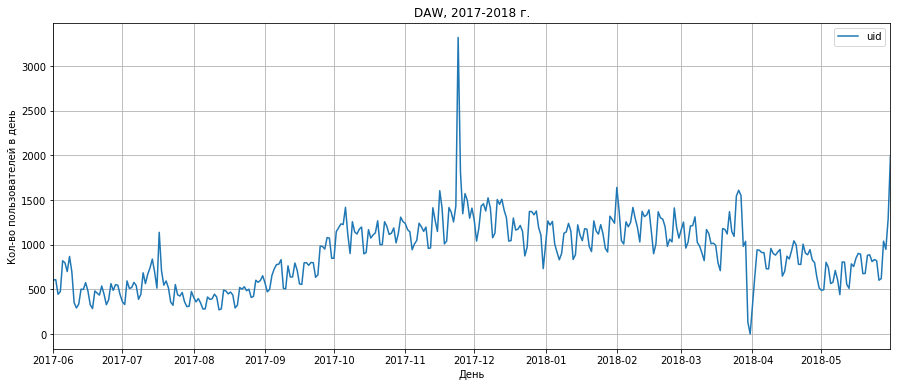

In [12]:
chart (dau, 
       'uid',
       'День', 
       'Кол-во пользователей в день', 
       'DAW, 2017-2018 г.')

На графике четко заметно что в предверии нового года пиковое кол-во новых посетителей видимо в это время маркетинг активно привлекал новых клиентов, и это понятно почему, все покупаю билеты на новогодние празники или смотрят куда можно сходить, при этом видно просадка в конце апреля, возможны проблемы с сервисом.

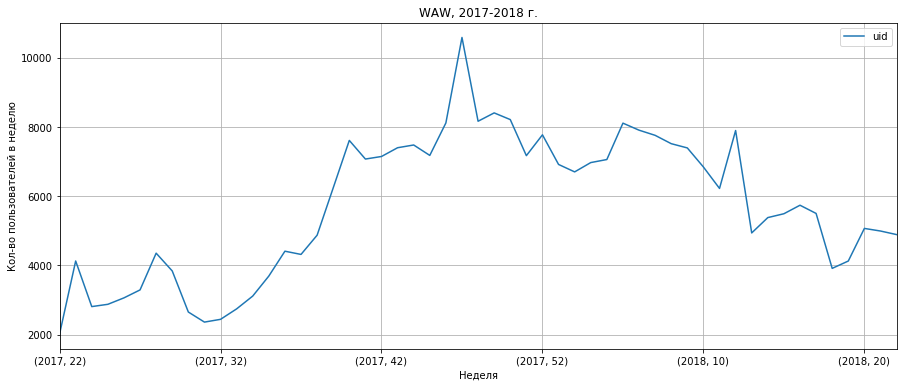

In [13]:
chart (wau, 
       'uid', 
       'Неделя', 
       'Кол-во пользователей в неделю', 
       'WAW, 2017-2018 г.')

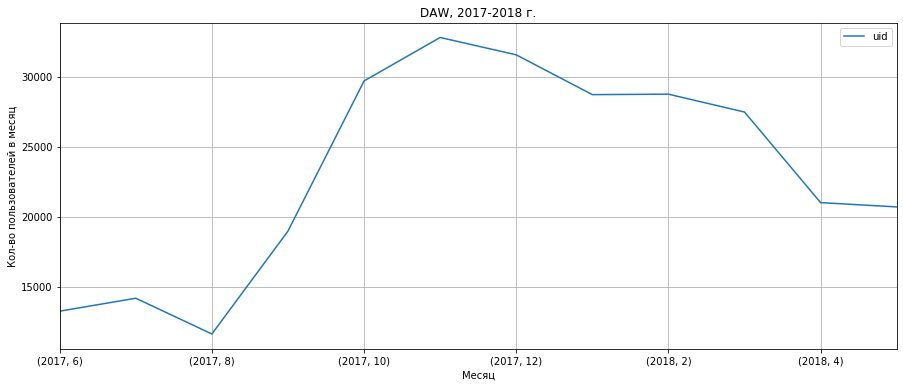

In [14]:
chart (mau, 
       'uid', 
       'Месяц', 
       'Кол-во пользователей в месяц', 
       'DAW, 2017-2018 г.')

Месячный и недельных график показывают очень похожие результаты, зимою кол-во новых поситителей увеличиваются, видимо это работа маркетинга, зимой они больше тратят на маркетинг, проверим это в будущем.

#### Определю, сколько раз за день пользователи в среднем заходят на сайт. 

In [15]:
visits_per_user = visits.groupby('session_date').agg({'uid': ['count','nunique']})
visits_per_user.columns = ['n_sessions', 'n_users']
visits_per_user['sess_per_user'] = visits_per_user['n_sessions'] / visits_per_user['n_users']
visits_per_user.mean()

n_sessions       987.362637
n_users          907.991758
sess_per_user      1.082170
dtype: float64

Отражу график среднего посещения за счет функции.

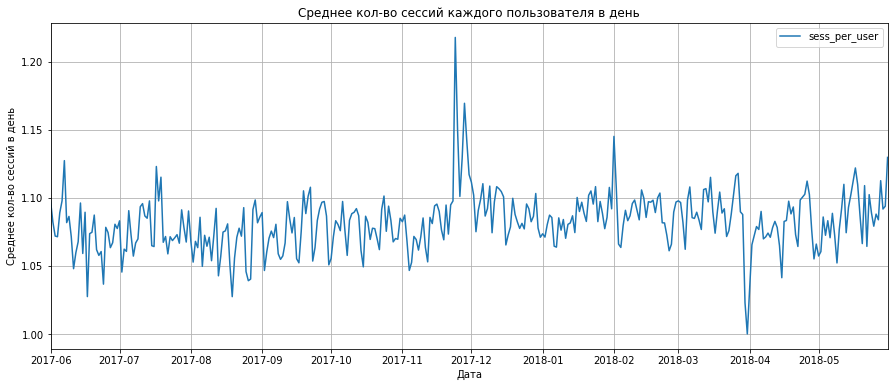

In [16]:
chart (visits_per_user, 
       'sess_per_user', 
       'Дата', 
       'Среднее кол-во сессий в день', 
       'Среднее кол-во сессий каждого пользователя в день')

Очень похожий график с DAU, тот же пик перед новым годом и падение в апреле, при это в течении года колебание среднего кол-ва сессий очень ровное.

#### Исследую, сколько времени пользователи проводят на сайте. 

Получу среднюю продолжительность посещения сайта в секундах, нулеввые значения считать не буду, так как нужно полчить данные о реальных пользователях. После построю график распределения 

Средняя продолжительность на сайте 11 минут
Мода продолжительности на сайте 1 минута


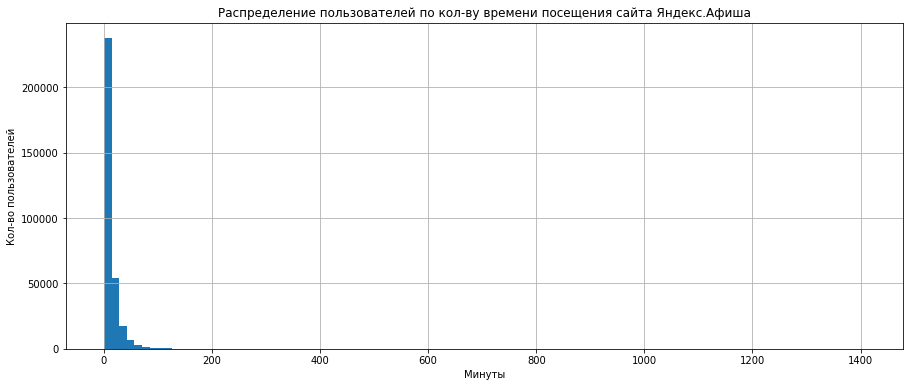

In [17]:
session_duration_min = (visits['end_ts'] - visits['start_ts']).dt.seconds
session_duration_min = (session_duration_min[session_duration_min > 0]) / 60
print('Средняя продолжительность на сайте' , int(session_duration_min.mean()), 'минут')
print('Мода продолжительности на сайте' , int(session_duration_min.mode()), 'минута')
session_duration_min.hist(bins=100, figsize=(15, 6))
plt.xlabel('Минуты')
plt.ylabel('Кол-во пользователей')
plt.title('Распределение пользователей по кол-ву времени посещения сайта Яндекс.Афиша')
plt.show()

По полученным данным видно что сильно большая часть поситетелей сайта не проводят на нем больше 30 минут, среднее значение равно 11 минут но мода равна минуте, и исходя из распределения я склонен доверять больше моде так как видно большое кол-во выбросов которые влияют на среднее.

#### Рассчитаю Retention Rate, применяя когортный анализ. 

Для начала найду даты первого посещения по каждому посетителю, т.у кагорту и помесяцный лайфтайм каждой кагорты

In [18]:
first_visits = visits.groupby('uid').agg({'start_ts':'min'})
first_visits.columns = ['first_start_ts']
new_visits= visits.merge(first_visits, on= 'uid')

new_visits['start_ts_month'] = new_visits['start_ts'].astype('datetime64[M]')
new_visits['first_start_ts_month'] = new_visits['first_start_ts'].astype('datetime64[M]')

new_visits['cohort_lifetime'] = new_visits['start_ts_month'] - new_visits['first_start_ts_month']
new_visits['cohort_lifetime'] = new_visits['cohort_lifetime'] / np.timedelta64(1, 'M')
new_visits['cohort_lifetime'] = new_visits['cohort_lifetime'].round().astype('int')
new_visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,first_start_ts,start_ts_month,first_start_ts_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,2018-03-09 20:05:00,2018-05-01,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,2018-03-09 20:05:00,2018-03-01,2018-03-01,0


Теперь сгрупирую таблицу по кагортам с количесвом уникальных пользователей,  получу количество пользоватетелей на первый месяц жизни и последующих, за счет эти данных расчитаю retention

In [19]:
cohorts = (new_visits.groupby([
    'first_start_ts_month', 
    'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
          )
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_start_ts_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid': 'cohort_users'})

cohorts = cohorts.merge(initial_users_count, on='first_start_ts_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']
cohorts.head()

,first_start_ts_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


Теперь создам сводную таблицу с retention и для лучшей визуализации обращусь seaborn.

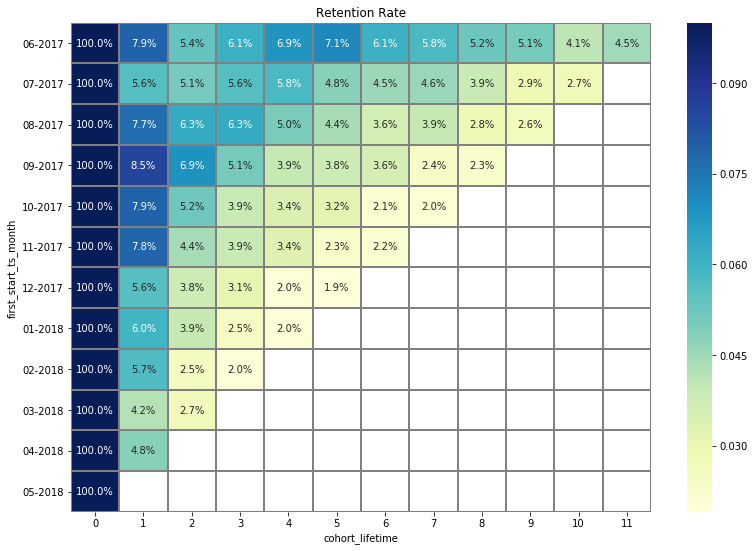

In [20]:
retention_pivot = cohorts.pivot_table(
    index='first_start_ts_month',
    columns='cohort_lifetime',
    values='retention'
)

plt.figure(figsize=(13, 9))
plt.title('Retention Rate')
sns.heatmap(retention_pivot,
            annot=True, 
            vmax=0.1,
            fmt='.1%', 
            linewidths=1, 
            linecolor='gray', 
            cmap="YlGnBu",
            yticklabels= retention_pivot.index.strftime('%m-%Y'))

Посчитаю средний retention второго месяца жизни корогт

In [21]:
second_life_cohorts = (cohorts[cohorts['cohort_lifetime'] == 1]) 
  
print('Средний Retention Rate второго месяца жизни когорт',((second_life_cohorts['retention']).mean() *100).round(2), '%')

Средний Retention Rate второго месяца жизни когорт 6.52 %


### Метрики электронной коммерции

#### Исследую, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки

Получу дату первой покупки, получу разницу времени посещения и покупки в часах, и переду данные в дни.

В среднем после первого посещения клиенту требуется 18 дней для совершения первой покупки
МОДА времени с момента входа на сайти до покупки 1 час


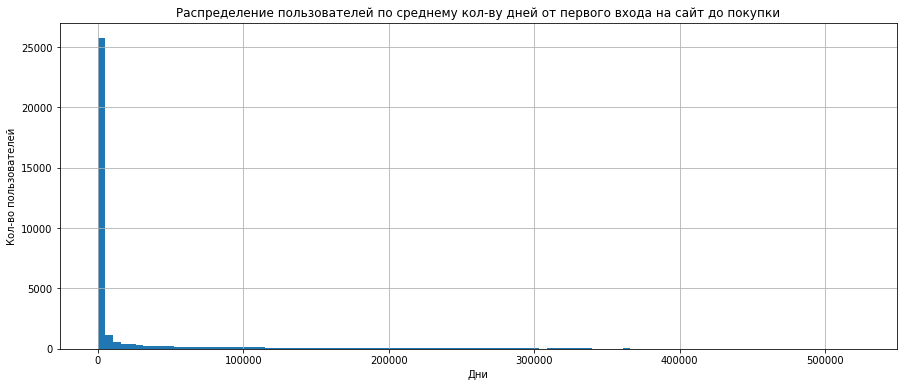

In [22]:
first_orders = orders.groupby('uid').agg({'buy_ts':'min'}).reset_index()
first_orders.columns = ['uid','first_buy']
buyers = first_orders.merge(first_visits, on = 'uid')
mean_time_for_buy = (
    buyers['first_buy'] - buyers['first_start_ts']) / np.timedelta64(1, 'm')

mean_time_for_buy = (mean_time_for_buy[mean_time_for_buy > 0 ]) 

print('В среднем после первого посещения клиенту требуется', int((mean_time_for_buy /60 / 24).mean()), 'дней для совершения первой покупки')
print('МОДА времени с момента входа на сайти до покупки', int((mean_time_for_buy).mode()), 'час')
mean_time_for_buy
mean_time_for_buy.hist(bins=100, figsize=(15, 6))
plt.xlabel('Дни')
plt.ylabel('Кол-во пользователей')
plt.title('Распределение пользователей по среднему кол-ву дней от первого входа на сайт до покупки')
plt.show()

график распределение напоминает количество времени проведенном на сайте, в нем тоже много выбросов которые могут влиять на среднее буду полагаться на моду.

#### Рассчитаю среднее количество покупок на одного покупателя за 6 месяцев

Подготовка данных будет как для получения retention, для начала высчитаю кагорты и помесяцный лайфтайм каждой кагорты и ограничу  срок жизни кагорт 6 месяцев

In [23]:
new_orders = orders.merge(first_orders, on ='uid')

new_orders['order_month'] = new_orders['buy_ts'].astype('datetime64[M]')
new_orders['first_order_month'] = new_orders['first_buy'].astype('datetime64[M]')

new_orders['life_time'] = (
    (new_orders['order_month'] - new_orders['first_order_month'])
    /np.timedelta64(1, 'M')
).round().astype('int')

new_orders.head()

,buy_ts,revenue,uid,first_buy,order_month,first_order_month,life_time
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0


теперь делаю сводную таблицу по кагортом, считаю среднее количество покупок по кагортам и делаю накопительную тепловую карту

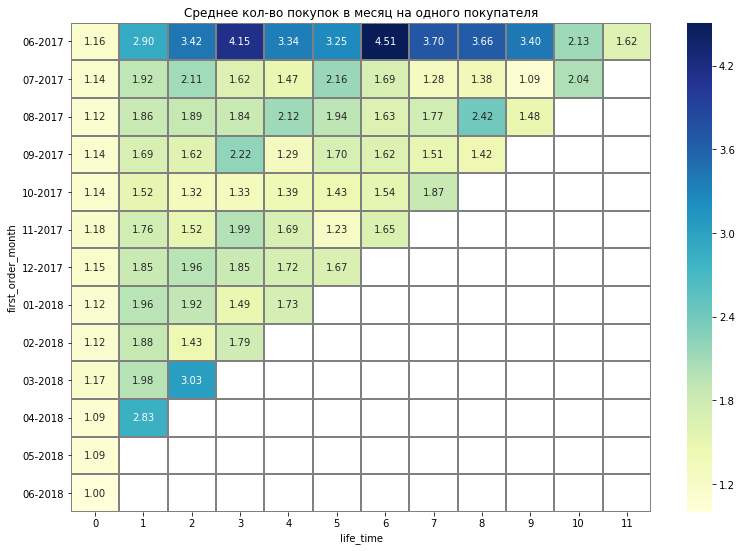

Средняя кол-во покупок одного покупателя по когортам в разрезе месяца : 1.9 шт


In [24]:
month_mean_purchase = new_orders.groupby(
    ['first_order_month', 'life_time']).agg(
    {'uid':['count', 'nunique']}).reset_index()

month_mean_purchase.columns = ['first_order_month', 'life_time', 'n_orders', 'n_users']
month_mean_purchase['orders_per_user'] = month_mean_purchase['n_orders'] / month_mean_purchase['n_users']

mean_purchase_pivot_table = month_mean_purchase.pivot_table(
    index = 'first_order_month', 
    columns = 'life_time', 
    values = 'orders_per_user', 
    aggfunc = 'mean')

plt.figure(figsize=(13, 9))
plt.title('Среднее кол-во покупок в месяц на одного покупателя')
sns.heatmap(mean_purchase_pivot_table, 
            annot=True, 
            fmt='.2f', 
            linewidths=1, 
            linecolor='gray', 
            cmap="YlGnBu", 
            yticklabels= mean_purchase_pivot_table.index.strftime('%m-%Y'))
plt.show()

mean_purchase = mean_purchase_pivot_table.mean().mean().round(1)
print('Средняя кол-во покупок одного покупателя по когортам в разрезе месяца :', mean_purchase, 'шт') 

среднее количество достигает потчи 2 покупок и по когортам я вижу что первая когорта чаще всего покупает в месяц, интересно из каих источников они пришли на сайт?

#### Рассчитаю средний чек, применяя группировку по времени совершения покупки

Начну с получения новых колонок с данными посещения по дням, неделям, месяцам и годам.

In [25]:
orders['purchase_year'] = orders['buy_ts'].dt.year
orders['purchase_month'] = orders['buy_ts'].dt.month
orders['purchase_week'] = orders['buy_ts'].dt.week
orders['purchase_date'] = orders['buy_ts'].dt.date
orders.head()

,buy_ts,revenue,uid,purchase_year,purchase_month,purchase_week,purchase_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017,6,22,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017,6,22,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017,6,22,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017,6,22,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017,6,22,2017-06-01


сгрупирую таблицу по дням и посторою график по среднему чеку с разбивкой по дням 

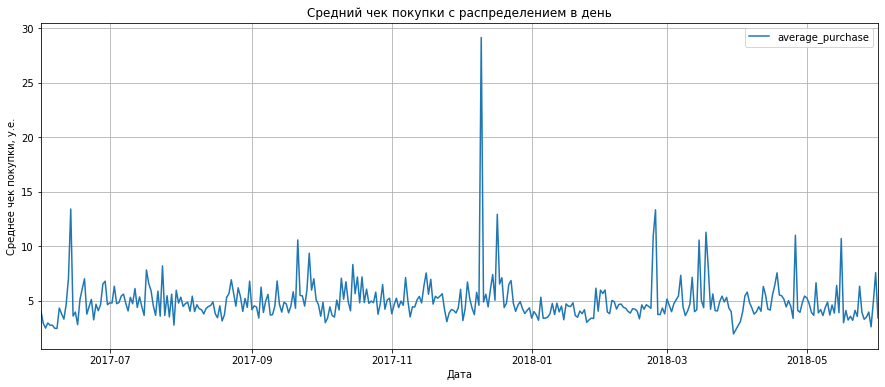

Средний чек покупки всех средних покупок за день: 4.94 y.e


In [26]:
orders_day = orders.groupby( 'purchase_date').agg({'revenue': ['sum', 'count']})
orders_day.columns = ['revenue_sum','purchase_count']
orders_day['average_purchase'] = orders_day['revenue_sum'] / orders_day['purchase_count']


    
chart (orders_day, 
       'average_purchase',
       'Дата', 
       'Среднее чек покупки, у.е.', 
       'Средний чек покупки с распределением в день')

print('Средний чек покупки всех средних покупок за день:',orders_day['average_purchase'].mean().round(2), 'y.e')

Сделаю то же самое с разбивкой по неделям и месяцам

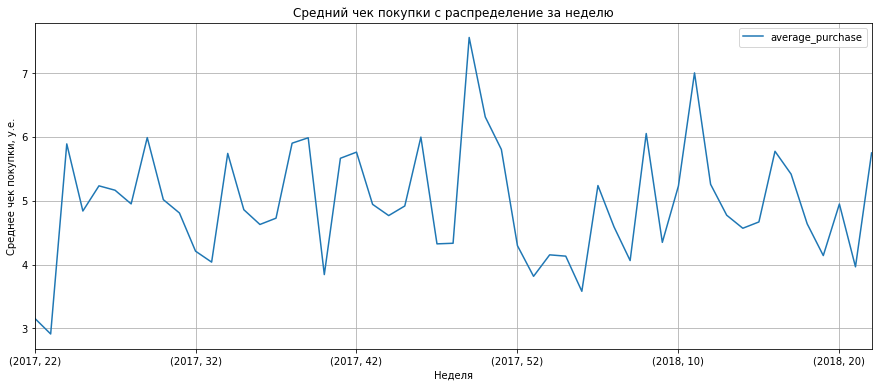

Средний чек покупки всех средних покупок за неделю: 5.0 y.e


In [27]:
orders_week = orders.groupby(['purchase_year', 'purchase_week']).agg({'revenue': ['sum', 'count']})
orders_week.columns = ['revenue_sum','purchase_count']
orders_week['average_purchase'] = orders_week['revenue_sum'] / orders_week['purchase_count']
   
chart (orders_week, 
       'average_purchase',
       'Неделя', 
       'Среднее чек покупки, у.е.', 
       'Средний чек покупки с распределение за неделю')

print('Средний чек покупки всех средних покупок за неделю:', orders_week['average_purchase'].mean().round(1), 'y.e')

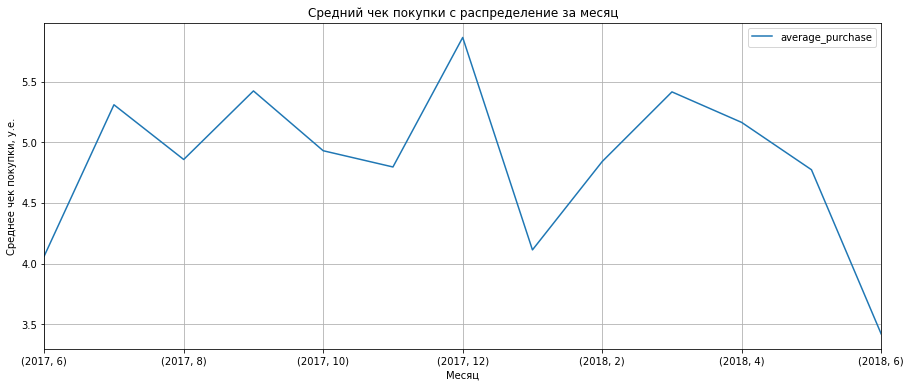

Средний чек покупки всех средних покупок за месяц: 5.0 y.e


In [28]:
orders_month = orders.groupby(['purchase_year', 'purchase_month']).agg({'revenue': ['sum', 'count']})
orders_month.columns = ['revenue_sum','purchase_count']
orders_month['average_purchase'] = orders_month['revenue_sum'] / orders_month['purchase_count']
    
chart (orders_month, 
       'average_purchase', 
       'Месяц', 
       'Среднее чек покупки, у.е.', 
       'Средний чек покупки с распределение за месяц')

print('Средний чек покупки всех средних покупок за месяц:', orders_week['average_purchase'].mean().round(1), 'y.e')

По графикам видно что средний чек увеличивается перед празниками, соответсвено после празников средний чек уменьшается

#### Выясню, как меняется LTV на покупателя по когортам. 

Для начала гляну на таблицу new_orders, в ней уже должны быдь ряд нужных мне столбов

In [29]:
display(new_orders.head())

,buy_ts,revenue,uid,first_buy,order_month,first_order_month,life_time
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0


Сгрупирую данные по когортам, получу LTV и сделаю сводную таблицу с накоплением LTV по месяцам

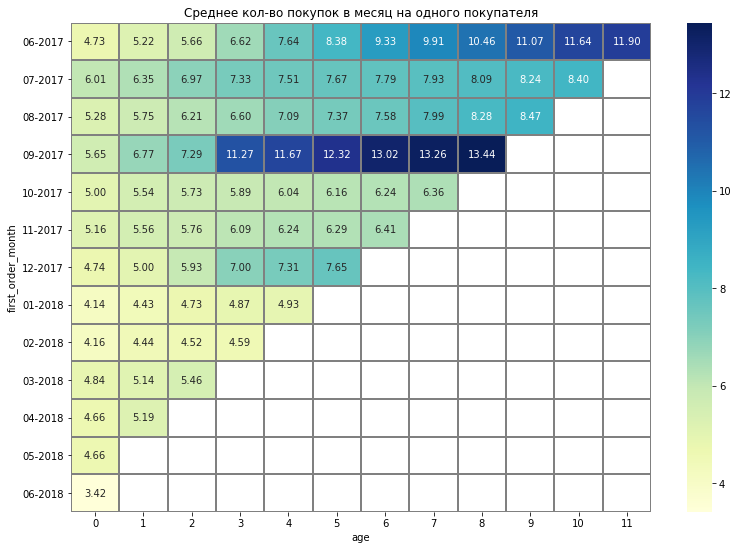

In [30]:
cohort_sizes = new_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()


cohort_sizes.columns = ['first_order_month', 'n_buyers']

cohorts = (
    new_orders.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)

report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')


report['age'] = report['age'].round().astype('int')

report['ltv'] = report['revenue'] / report['n_buyers']


output = report.pivot_table(
    index='first_order_month', 
    columns='age', values='ltv', 
    aggfunc='mean').round(2)

output = output.cumsum(axis = 1)

plt.figure(figsize=(13, 9))
plt.title('Среднее кол-во покупок в месяц на одного покупателя')
sns.heatmap(output, 
            annot=True, 
            fmt='.2f', 
            linewidths=1, 
            linecolor='gray', 
            cmap="YlGnBu", 
            yticklabels= output.index.strftime('%m-%Y'))
plt.show()


Получу среднее LTV за 6 месяцев по когортам прожившие 6 или более, для это отфильтрую сводную таблицу.

In [31]:
ltv_mean_six_month = output.iloc[0:7, 5].mean().round(2)
print('Средняя LTV за 6 месяцев по когортам прожившие 6 или более месяцем:', ltv_mean_six_month, 'y.e.') 

Средняя LTV за 6 месяцев по когортам прожившие 6 или более месяцем: 7.98 y.e.


### Маркетинговые метрики

#### Посчитаю общую сумму расходов на маркетинг. 

Сгрупирую таблицу по типам источников затрат, и получим суммы по источникам и общую сумму затрат.

In [32]:
sources_sum_table =costs.groupby('source_id').agg({'costs':'sum'})
display(sources_sum_table.sort_values('costs',ascending = False))
sources_sum = int((sources_sum_table).sum())
print('Общая сумма на маркетинг', sources_sum, 'y.e')

,costs
source_id,
3,141321.63
4,61073.60
5,51757.10
2,42806.04
1,20833.27
10,5822.49
9,5517.49


Общая сумма на маркетинг 329131 y.e


Теперь сгрупирую данные по месяцам и посмотрю распределение трат во времени, как общую сумму так отдельно по источникам

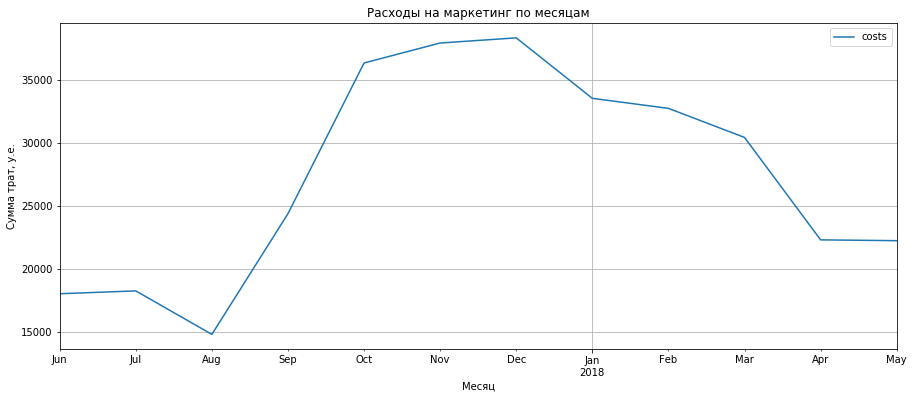

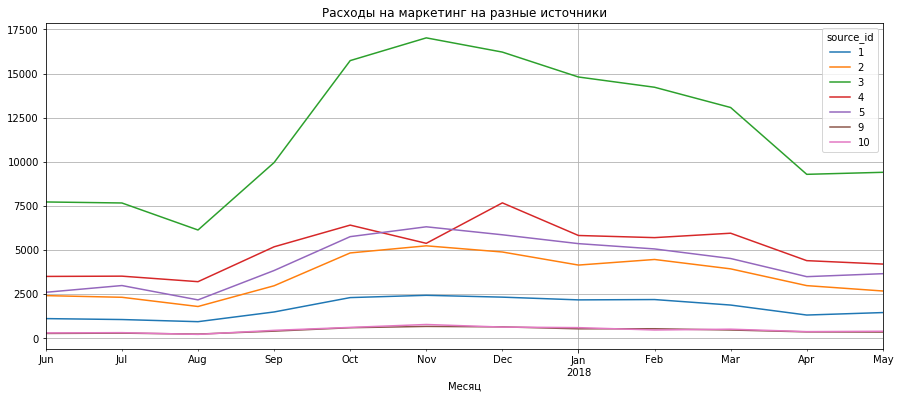

In [33]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs_by_month = costs.groupby(['month']).agg({'costs':'sum'})

chart (costs_by_month, 
       'costs', 
       'Месяц', 
       'Сумма трат, у.е.', 
       'Расходы на маркетинг по месяцам')

costs_sources = costs.pivot_table(index = 'month', columns = 'source_id', values = 'costs', aggfunc = 'sum')
costs_sources.plot(figsize = (15,6), grid=True, title = 'Расходы на маркетинг на разные источники')
plt.xlabel('Месяц')
plt.show()


Мои ранние предположения аказались верные, маркетинг и правда в земнее время вкладывает на привлечение больше денег, видимо делают выводы что летом у клиентов есть занятия по интереснее чем делать покупкина яндекс афише

Дополнительно вижу что в источник №1 вкладывают больше всего денег, проверю в будущем окупается ли он

#### Рассчитаю средний CAC на одного покупателя для всего проекта и для каждого источника трафика. 

Для начала найду средний САС на одного покупателя, возьму общую сумму затрат и разделю их на количество покупателей 

In [34]:
buyers_sum = len(orders['uid'].unique())
averange_cac = round((sources_sum / buyers_sum), 2)
print('Средний САС на одного покупателя', averange_cac, 'y.e.')

Средний САС на одного покупателя 9.02 y.e.


А теперь найду средний САС по каждому источнику, а так же по дате. Разделю получения нужных мне данных на 5 этапов 

1. Продвигаясь по  проекту я уже подготовил нужные мне таблицы, их я и начну мержить что бы получить таблицу с источниками, клиентами и с первым месяцем покупки.
2. А теперь сгрупирую из полученной таблицы количество покупателей по источникам и месяцем первого посещения сайта
3. Сгрупирую траты по источникам и месяцам трат
4. Замержу обе получившиеся сгрупированных таблиц, и получу САС.

И конечно выведу визуализацию))

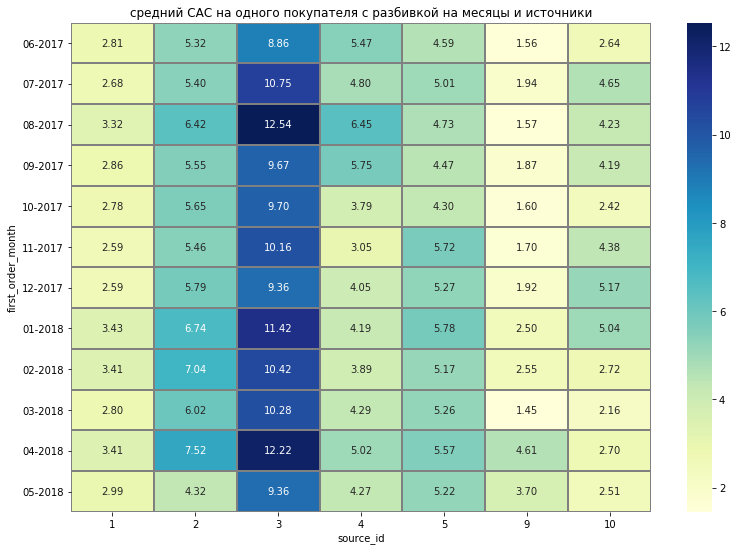

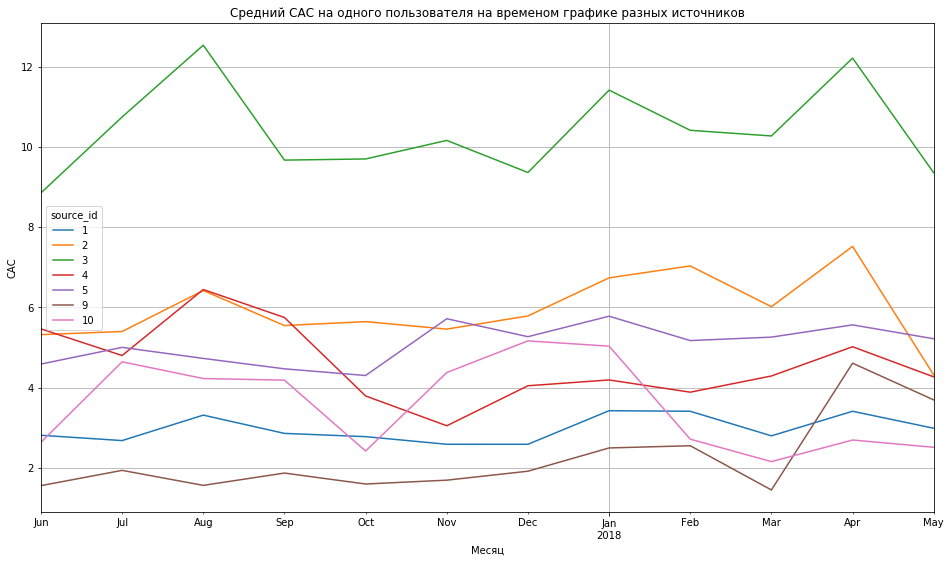

In [35]:
first_orders['first_order_month'] = first_orders['first_buy'].astype('datetime64[M]')#добавил месяц первой покупки

#вместо дату первого посещения использую дату первой покупки
 
orders_and_sources = pd.merge(new_visits, first_orders, on='uid', how='left')
orders_and_sources = orders_and_sources.dropna()#удалил поситителей без покупок

soruce_by_buyers = orders_and_sources.groupby(['source_id', 'first_order_month']).agg({'uid':'nunique'}).reset_index()
soruce_by_buyers.columns = ['source_id', 'first_order_month', 'n_buyers']

source_by_costs = costs.groupby(['source_id', 'month']).agg({'costs':'sum'}).reset_index()

general_costs = pd.merge(soruce_by_buyers, 
                         source_by_costs, 
                         left_on =['source_id', 'first_order_month'], 
                         right_on=['source_id', 'month'])
general_costs['costs_per_buyer'] = general_costs['costs'] / general_costs['n_buyers']

general_cac = general_costs.pivot_table(index = 'first_order_month', 
                                        columns = 'source_id', 
                                        values = 'costs_per_buyer', 
                                        aggfunc = 'mean')

plt.figure(figsize=(13, 9))
plt.title('средний CAC на одного покупателя с разбивкой на месяцы и источники')
sns.heatmap(general_cac, 
            annot=True, 
            fmt='.2f', 
            linewidths=1, 
            linecolor='gray', 
            cmap="YlGnBu",
            yticklabels= general_cac.index.strftime('%m-%Y'))
plt.show()

general_cac.plot(figsize=(16,9), grid=True, title = 'Средний САС на одного пользователя на временом графике разных источников')
plt.xlabel('Месяц')
plt.ylabel('CAC')
plt.show()


Вижу что самые высокий САС в 3 источнике, и в него в течении 12 месяцев  стабильно вкладывают деньги

#### Рассчитаю ROMI по когортам в разрезе источников. Построю графики, отражающие изменения метрик во времени.

Смержу 2 таблицы, визиты и заказы, но для начала оставлю в них нужные столбцы и отсортирую визиты по первому посещению:

In [36]:
new_orders_short = new_orders[['revenue', 'uid', 'order_month', 'first_order_month']]
new_visits_short = new_visits[['source_id', 'uid', 'first_start_ts']]
new_visits_short = new_visits_short.sort_values('first_start_ts').groupby('uid').first().reset_index()

custumers_orders = pd.merge(new_visits_short, new_orders_short, on='uid', how='left')
custumers_orders = custumers_orders.dropna()# удалил поситителей без заказов
custumers_orders.head()

,uid,source_id,first_start_ts,revenue,order_month,first_order_month
3,313578113262317,2,2017-09-18 22:49:00,0.55,2018-01-01,2018-01-01
22,1575281904278712,10,2017-06-03 10:13:00,1.22,2017-06-01,2017-06-01
23,1575281904278712,10,2017-06-03 10:13:00,1.83,2017-06-01,2017-06-01
36,2429014661409475,3,2017-10-11 17:14:00,73.33,2017-10-01,2017-10-01
37,2464366381792757,5,2018-01-27 20:10:00,2.44,2018-01-01,2018-01-01


Теперь групирую полученую таблиицу по заказам и когортам, значения устанавливаю количество уникальных пользователей и сумма заказов.

Затем получаю срок жизни когорт, и мёржу получившуюся таблицу с тратами.  

In [37]:
counted_custumers_orders = custumers_orders.groupby(['source_id', 
                             'first_order_month', 
                             'order_month']).agg({'uid': 'nunique', 
                                                  'revenue':'sum'}).reset_index()

counted_custumers_orders['lifetime'] = (
    (counted_custumers_orders['order_month'] - counted_custumers_orders['first_order_month']) / np.timedelta64(1, 'M')
).round().astype('int')

romi = counted_custumers_orders.merge(source_by_costs, 
                                     left_on =['source_id', 'first_order_month'],
                                     right_on=['source_id', 'month'])
romi.head()

,source_id,first_order_month,order_month,uid,revenue,lifetime,month,costs
0,1,2017-06-01,2017-06-01,217,1266.76,0,2017-06-01,1125.61
1,1,2017-06-01,2017-07-01,15,285.94,1,2017-06-01,1125.61
2,1,2017-06-01,2017-08-01,14,192.23,2,2017-06-01,1125.61
3,1,2017-06-01,2017-09-01,14,402.51,3,2017-06-01,1125.61
4,1,2017-06-01,2017-10-01,14,737.88,4,2017-06-01,1125.61


Добавляю в таблицу нужные метрики

In [38]:
romi['ltv'] = romi['revenue'] / romi['uid']
romi['cac'] = romi['costs'] / romi['uid']
romi['romi'] = romi['ltv'] / romi['cac']
romi.head()

,source_id,first_order_month,order_month,uid,revenue,lifetime,month,costs,ltv,cac,romi
0,1,2017-06-01,2017-06-01,217,1266.76,0,2017-06-01,1125.61,5.837604,5.187143,1.125399
1,1,2017-06-01,2017-07-01,15,285.94,1,2017-06-01,1125.61,19.062667,75.040667,0.254031
2,1,2017-06-01,2017-08-01,14,192.23,2,2017-06-01,1125.61,13.730714,80.400714,0.170779
3,1,2017-06-01,2017-09-01,14,402.51,3,2017-06-01,1125.61,28.750714,80.400714,0.357593
4,1,2017-06-01,2017-10-01,14,737.88,4,2017-06-01,1125.61,52.705714,80.400714,0.655538


А теперь создам цикл с выводом сводной таблицы с метриками ROMI по когортам в разрезе источников

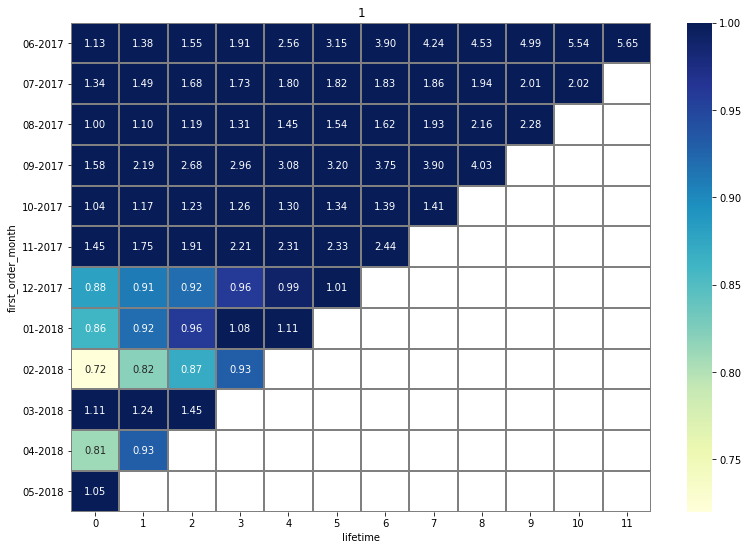

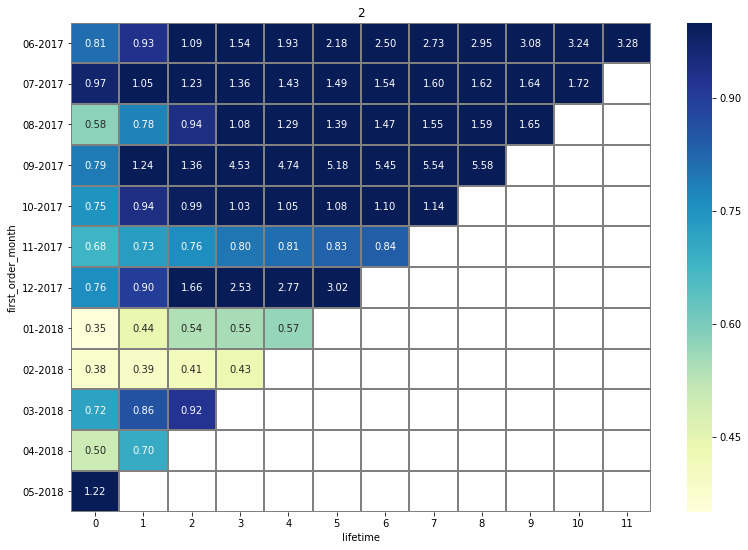

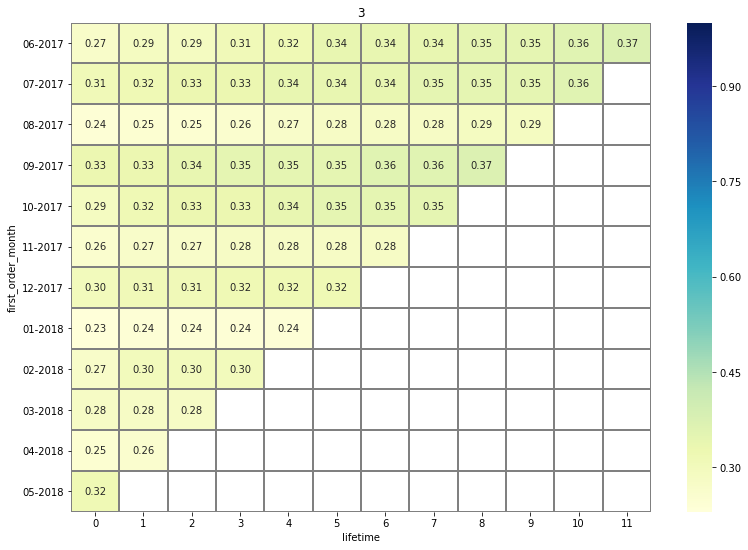

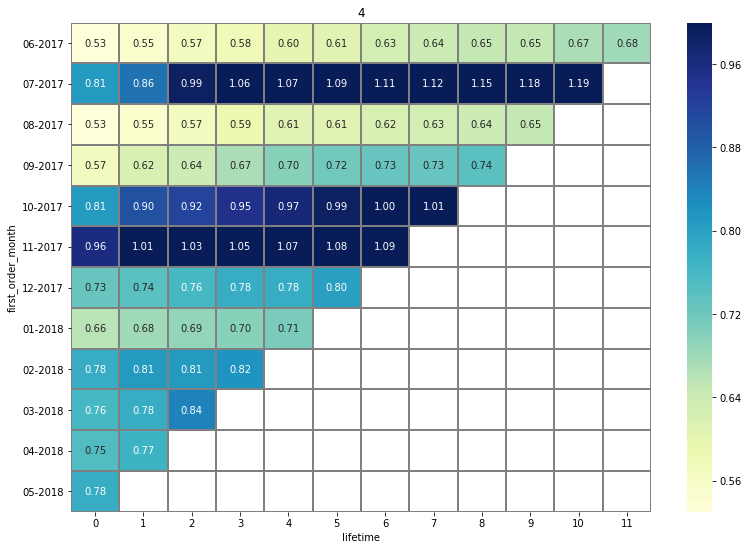

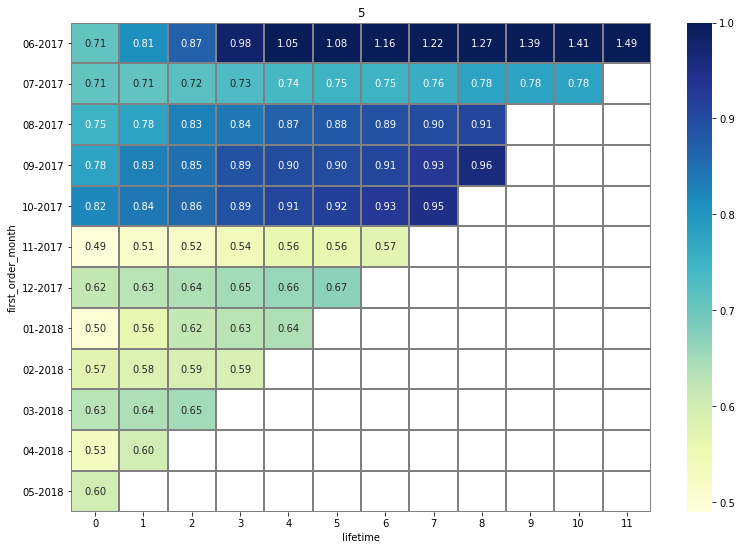

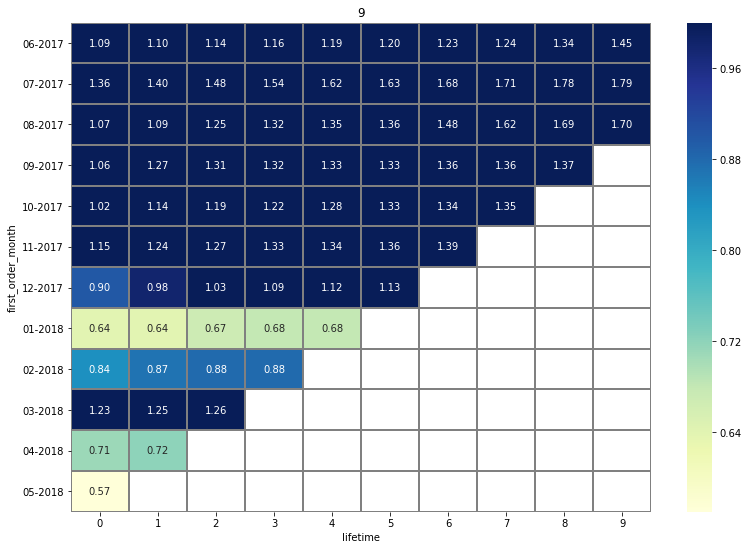

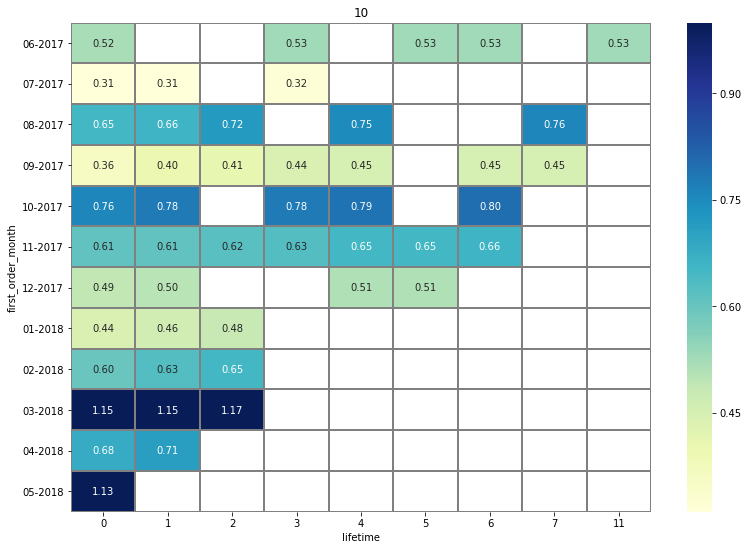

In [39]:
sources_id = romi['source_id'].unique()
 
for i in sources_id:
 
    cycle_romi = romi.query('source_id == @i')
    cycle_romi_pivot = cycle_romi.pivot_table(index = 'first_order_month', 
                                  columns = 'lifetime', 
                                  values = 'romi').cumsum(axis=1).round(2) 
    plt.figure(figsize=(13, 9))
    plt.title(i)
    sns.heatmap(cycle_romi_pivot,
                annot=True, 
                vmax=1,
                fmt='.2f', 
                linewidths=1, 
                linecolor='gray', 
                cmap="YlGnBu", 
                yticklabels= cycle_romi_pivot.index.strftime('%m-%Y'))
    

Источники 1, 2 и 9 возмещают вложенные деньги в среднем со врторго месяца как видно из тепловых карт, на них необходимо обратить внимание.
Источник 3 хуже всех возмещает день при самых высоких вложениях.
В остальные источниках информация по разным кагортам отличается, есть кагорты где окупаемость наступает с первого месяца но может в следующей и через 6 месяцев не окупится.

## Выводы

Из полученым данных вижу что Яндекс.Афиша выделяет наибольшее количество средств для получения заказов в источник №3, и  со временем только увеличивают вложения, в предпоследний месяц средний САС достигает  почти 17 у.е., (общий средний САС всех источников в разрезе когорт равен 5.3 у.е.),  дополнительно мы видим что ROMI по всем когортам в 3 источнике не растет, и среднем находится на уровне 0.3 у.е., даже на протежении годовой жизни когорты. Это четкий сигнал маркетингу снизить вложения в данный источник.
Обратная картина наблюдается с источниками № 1 и № 2, их окупаемость в первых когортах точно достигала в течениии первых четырех месяцев жизни, в последних когортах ROMI уже меньше но это по причине увеличения САС, маркетингу нужно продолжить увеличивать вложения в данные источники для последующего маштабирования эффекта который был получен ранее.
 
Дополнительно к вышеизложенному, retention демонструет низкий процент в последних кагортах что еще раз говорит что маркетингу нужно сменить стартегию по избыточным затратам в сточник 3 и 5. 

Так же маркетингу стоит обратит внимание на привлечение клиентов перед праздниками, в данных четко видно что клиенты начинают увеличивають сумму средней покупки перед праздниками, возможно это поможет добится лучшей прибыльности продукта.

Самой же выгодной когортой в наших данных оказывается первая, при меньших затратах были привлечены клиенты которые регулярно делают заказы. При смене стратегии расходов отделом маркетинга исходя из рекомендаций выше, думаю в будущем компанию Яндекс.Афиша ждем когорты еще вогоднее)) 
